In [1]:
%pylab inline
import numpy as np
import sklearn
#from sklearn.preprocessing import Imputer
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
import pandas as pd
import pickle

Populating the interactive namespace from numpy and matplotlib


In [2]:
def read_data_samples():
    with open('data/lightcurves.pickle', 'rb') as file:
        lightcurves = pickle.load(file)
    data = lightcurves
    return data

In [3]:
data = read_data_samples()
pca = data['pca']
flux = pca['flux_pca']
meta_data = pca['metadata_pca']
phase = data['phase']

In [4]:
print(flux.shape)

(3873, 300)


In [5]:
def return_synthetic_data(X):
    """
    The function returns a matrix with the same dimensions as X but with synthetic data
    based on the marginal distributions of its featues
    """
    features = X.shape[1]
    X_syn = numpy.zeros(X.shape)

    for i in range(features):
        obs_vec = X[:,i]
        syn_vec = numpy.random.choice(obs_vec, len(obs_vec)) # here we chose the synthetic data to match the marginal distribution of the real data
        X_syn[:,i] += syn_vec

    return X_syn

X_syn = return_synthetic_data(flux)

In [6]:
print(flux)
print(X_syn)

[[ 0.87039603  0.89207965  0.9340022  ...  0.77572262  0.98799521
   0.94057749]
 [ 0.89157942  0.88564134  0.88251    ...  0.87349786  0.87208494
   0.85858583]
 [ 1.0331203   1.10943235  0.77404528 ...  0.7454127   1.14610694
   0.57260888]
 ...
 [ 1.23220703  1.34989259  0.56704751 ...  1.60950911  0.53090642
  -0.5076051 ]
 [ 0.98968787  1.17763284  1.05577175 ...  0.90162656  1.12397758
   0.91814753]
 [-0.19865873  1.43994627  1.98398724 ...  0.50902667  0.28158479
  -0.70096411]]
[[ 0.95087771  1.35048693  1.0513435  ...  0.65829069  1.1402684
   1.35293877]
 [ 1.0033295   0.91572732  0.43218899 ...  0.88677084  0.65853938
   1.59877533]
 [ 1.53164962  0.08739923 -0.10313909 ...  1.45943237  2.39459419
  -0.40527259]
 ...
 [ 0.89026055  1.66417424  0.54751493 ...  2.21856371  1.35518221
   1.02616562]
 [ 0.34482245 -0.01797493  1.19562508 ...  0.87965226  0.55037004
   0.66455338]
 [ 1.02148401  1.22682722  0.83445962 ...  0.67047639  0.15122623
   1.4188236 ]]


100
250


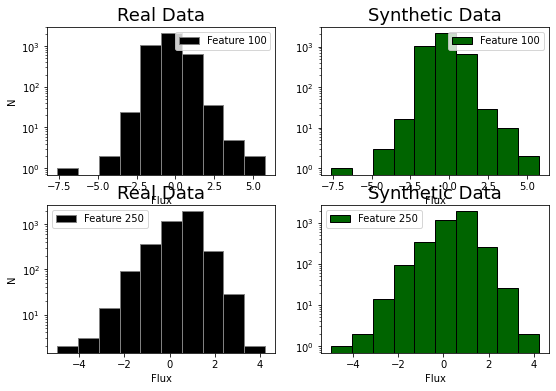

In [7]:
# plots synthetic features against real data checking correct distribution has been achieved.
plt.rcParams['figure.figsize'] = 8, 6
T=[100,250]
j=-1
plt.rcParams['figure.figsize'] = 9,6
for i in T:
    j=j+2
    print(i)
    plt.subplot(2,2,j)
    plt.title('Real Data',fontsize=18)
    plt.hist(flux[:, i] ,color="k",edgecolor='grey', label="Feature {}".format(i))
    plt.yscale('log')
    plt.legend(loc='best')
    plt.xlabel('Flux')
    plt.ylabel('N')
    
    plt.subplot(2,2,j+1)
    plt.title('Synthetic Data',fontsize=18)
    plt.hist(X_syn[:, i], color="darkgreen",edgecolor='black', label="Feature {}".format(i))
    plt.yscale('log')
    plt.xlabel('Flux')
    plt.legend(loc='best')


In [8]:
def merge_work_and_synthetic_samples(X, X_syn):
    """
    The function merges the data into one sample, giving the label "1" to the real data and label "2" to the synthetic data
    """
    # build the labels vector
    Y = numpy.ones(len(X))
    Y_syn = numpy.ones(len(X_syn)) * 2

    Y_total = numpy.concatenate((Y, Y_syn))
    X_total = numpy.concatenate((X, X_syn))
    return X_total, Y_total

In [9]:
X_total, Y_total = merge_work_and_synthetic_samples(flux, X_syn)

print(X_total.shape, Y_total.shape)
print(np.unique(Y_total))


(7746, 300) (7746,)
[1. 2.]


In [10]:
# declare an RF
N_TRAIN = 50 # number of trees in the forest
#m_depths = [1,5,10,50,100,500,1000] # number of trees in the forest
scores = []
#for ene in N_TRAIN:
rand_f = RandomForestClassifier(n_estimators=N_TRAIN, 
                                                    max_features='log2', max_depth=100,
                                                min_impurity_decrease=0.000001,min_samples_split=3,
                                                bootstrap=False,warm_start=False, random_state=0)
rand_f.fit(X_total, Y_total)
y_pred = rand_f.predict(X_total[4000:])
scores.append(rand_f.score(X_total[4000:],Y_total[4000:]))
print(np.unique(y_pred), np.unique(Y_total))

[2.] [1. 2.]


In [11]:
imp = rand_f.feature_importances_
print(imp)

[0.00267867 0.00301731 0.0029227  0.00274388 0.00332338 0.00255462
 0.0029976  0.0027993  0.00268652 0.00287997 0.00288133 0.00239812
 0.0027902  0.00226728 0.00306414 0.00289765 0.00280531 0.00299157
 0.00280101 0.00252344 0.00274832 0.00269107 0.00284732 0.0028261
 0.00261095 0.00290898 0.00275222 0.00269162 0.00270779 0.00257993
 0.00249436 0.00282522 0.00295002 0.00255614 0.00268108 0.00282521
 0.0021894  0.00248868 0.0023182  0.00285269 0.00303947 0.00240747
 0.00289621 0.00286404 0.00271675 0.00268543 0.00283909 0.00250241
 0.00325948 0.0024632  0.00270876 0.00276838 0.00249626 0.00237023
 0.00278303 0.00348346 0.00293053 0.00260184 0.00236315 0.00300818
 0.00274847 0.0033904  0.00284776 0.00271239 0.00295766 0.00302863
 0.00276842 0.00267351 0.00243885 0.00245712 0.00294623 0.002557
 0.00236397 0.00283384 0.0029073  0.00338185 0.00219717 0.00265255
 0.00259362 0.00244323 0.00247048 0.00251224 0.00254977 0.00220816
 0.00232266 0.00262573 0.00247074 0.00287834 0.00248318 0.0024984

In [12]:
model = SelectFromModel(rand_f, prefit=True)

In [13]:
#
# Mask for the selected features
#
selected_features=model.get_support()
#
# Return scores for the features [only for tree-based classifiers]
#
features_score=rand_f.feature_importances_

In [14]:
print(f"Masked Selected Features are: {selected_features}\n\n Features' score is: {features_score}")

Masked Selected Features are: [False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False  True False False False False
 False  True False False False False False False False False False False
 False False False  True False False False False False False False False
 False False False False False False False False False False False False
 False False  True False  True  True False False False False False False
  True  True False False  True  True False  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  T

In [15]:
features = np.arange(300)
feature_set = [y for x,y in zip(selected_features, features) if x]
print(feature_set)
feature_set_score=features_score[selected_features]
print(feature_set_score)

[55, 61, 75, 98, 100, 101, 108, 109, 112, 113, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 190, 191, 192, 193, 194, 195, 199, 229, 234, 238, 252, 282, 297]
[0.00348346 0.0033904  0.00338185 0.00335796 0.00335016 0.00334833
 0.00394091 0.00439416 0.00377028 0.00353912 0.00480061 0.00375504
 0.00413229 0.00446861 0.00334981 0.00490283 0.00433323 0.00571584
 0.00448501 0.00645533 0.00384701 0.00458633 0.00433625 0.00543833
 0.00473724 0.00390203 0.0051991  0.0047379  0.00506249 0.00402223
 0.0048461  0.00553778 0.00743263 0.00584586 0.00580356 0.00436059
 0.00482706 0.00526351 0.00521024 0.00597641 0.00522134 0.00517859
 0.00544855 0.0049961  0.00479136 0.00543597 0.00

In [19]:
sorted_set = sorted(zip(feature_set, feature_set_score), key=lambda x: x[1], reverse=True)

In [22]:
sorted_set

[(137, 0.00743262840283167),
 (178, 0.006711542464641204),
 (124, 0.006455325135160905),
 (163, 0.006333593547580237),
 (144, 0.005976411052410293),
 (169, 0.005928331787669966),
 (170, 0.005891582400505784),
 (157, 0.005873699147145881),
 (138, 0.005845862433566479),
 (139, 0.005803560344592939),
 (174, 0.005766114174432165),
 (159, 0.005721292463560129),
 (122, 0.005715836332763323),
 (156, 0.005709776542539554),
 (154, 0.005667918780083892),
 (153, 0.005547971377930601),
 (136, 0.005537781013566727),
 (155, 0.005521481982144929),
 (167, 0.005462831194477332),
 (147, 0.005448547948578395),
 (128, 0.005438330530534936),
 (150, 0.005435967118243396),
 (151, 0.0053785152538658254),
 (160, 0.005377841099181924),
 (142, 0.005263512593958996),
 (145, 0.005221344091104362),
 (143, 0.005210241004249729),
 (131, 0.005199098968217911),
 (146, 0.00517859271586879),
 (172, 0.005134376734558636),
 (133, 0.005062494525691799),
 (148, 0.004996104377041195),
 (152, 0.004964910199283398),
 (120, 0.00

NameError: name 'm_depths' is not defined

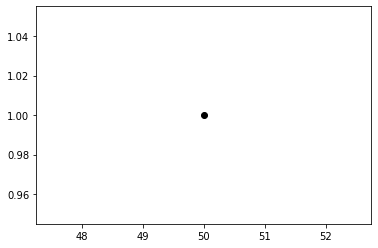

In [16]:
from matplotlib.ticker import ScalarFormatter
plt.rcParams['figure.figsize'] = 6, 4
plt.scatter(N_TRAIN,scores,color='black')
plt.plot(N_TRAIN,scores,color='black')
plt.scatter(m_depths,scores1,color='gray')
plt.plot(m_depths,scores1,color='gray')
plt.xscale('log')
plt.xlabel('max_depth',size=15)
plt.ylabel('Accuracy',size=15)
plt.xticks([1,10,100,1000])
ax = gca().xaxis
ax.set_major_formatter(ScalarFormatter())
#plt.savefig('maxdepth_accuracy.ps',dpi=300,bbox_inches='tight')
#ax.set_ticklabel_format(style='plain', axis='x')

In [17]:
importances = rand_f.feature_importances_
std = np.std([rand_f.feature_importances_ for tree in rand_f.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking for the top 20 most important features
print("Feature ranking:")

for f in range(20):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

Feature ranking:
1. feature 172 (0.007533)
2. feature 139 (0.007206)
3. feature 158 (0.007049)
4. feature 163 (0.006563)
5. feature 140 (0.006376)
6. feature 147 (0.006248)
7. feature 171 (0.006148)
8. feature 136 (0.006139)
9. feature 174 (0.005934)
10. feature 167 (0.005910)
11. feature 148 (0.005842)
12. feature 150 (0.005829)
13. feature 157 (0.005769)
14. feature 141 (0.005729)
15. feature 149 (0.005684)
16. feature 121 (0.005650)
17. feature 135 (0.005638)
18. feature 164 (0.005637)
19. feature 165 (0.005603)
20. feature 166 (0.005603)


300


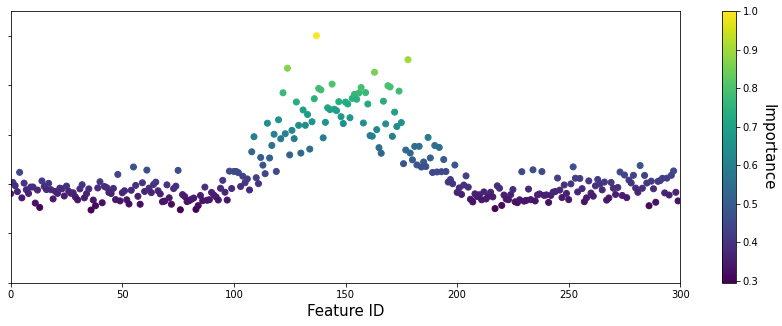

In [28]:
# Plot the features and their importances
importances = rand_f.feature_importances_
print(len(importances))
feats = arange(len(importances))
# print(feats)
# plt.rcParams['figure.figsize'] = 18, 4
plt.figure(figsize=(15, 5))
#plt.axvline(x=337, color='r')
# plt.axvline(x=3520, color='black',linewidth=1)
cm = plt.cm.get_cmap('viridis')
im = plt.scatter(feats,importances/np.max(importances),c=importances/np.max(importances),cmap=cm)
im.axes.yaxis.set_ticklabels([])
#xlim(0,637)
xlim(0,300)
ylim(0, 1.1)
# plt.text(1300,1.25,'Light curve fluxes',size=15)
# plt.text(4600,1.25,'Spectral power',size=15)
# plt.text(5400,1.15,'Short periods (hours)',size=12)
# plt.text(3634,1.15,'Long periods (weeks)',size=12)
#print(np.sum(importances[:3234]),np.sum(importances[3234:]))
plt.xlabel('Feature ID',size=15)
cbar = plt.colorbar(im,pad=0.05)
cbar.set_label('Importance',size=15,rotation=270,labelpad=17)

In [74]:
light_curves=3873
def build_similarity_matrix(rand_f, X):
    """
    The function builds the similarity matrix based on the feature matrix X for the results Y
    based on the random forest we've trained
    the matrix is normalised so that the biggest similarity is 1 and the lowest is 0

    This function counts only leaves in which the object is classified as a "real" object 
    it is also implemented to optimize running time, asumming one has enough running memory
    """

    # apply to get the leaf indices
    apply_mat = rand_f.apply(X)
#     print(apply_mat.shape)
    # find the predictions of the sample
    is_good_matrix = np.zeros(apply_mat.shape)
#     print(is_good_matrix)
    for i, est in enumerate(rand_f.estimators_):
#         print("2222::: ",est.predict_proba(X)[1, 1])
        d = est.predict_proba(X)[:, 0] == 1
#         print("3333::: ",d)
#         print("4444::: ",est.classes_)
        is_good_matrix[:, i] = d
#         print("44444::: ", is_good_matrix, np.unique(is_good_matrix))
    # mark leaves that make the wrong prediction as -1, in order to remove them from the distance measurement
    apply_mat[is_good_matrix == False] = -1
#     print(np.max(apply_mat))
    leaf_pop=np.zeros((np.max(apply_mat[:,:]+1),N_TRAIN))
    for i in range(light_curves):
        for j in range(N_TRAIN):
            if apply_mat[i,j]!= -1:
                leaf_pop[apply_mat[i,j],j]+=1
                
    print(leaf_pop)
    
    #used to normalize and wieght the results heavily towards trees that corretly identify objects as real or synthetic
    Normalization=np.sum(leaf_pop,axis=0)
    Norm_mean=np.mean(Normalization)
    print('Normalization=',Normalization.shape, Norm_mean)
    
    #creates the similarity matrix by using the leaf populations rather then pair matching each light curve
    sim_vec=np.zeros(light_curves)
    for i in range(light_curves):
        for j in range(N_TRAIN):
            sim_vec[i]+=(leaf_pop[(apply_mat[i,j]),j])/Normalization[j] #adds normalization here '/Normalization[j]'
    
    print(sim_vec)
#     sim_vec/= float(len(sim_vec-1))*N_TRAIN
    sim_vec/= N_TRAIN
    print(sim_vec)
    return sim_vec



In [75]:
sim_matrix = build_similarity_matrix(rand_f, flux)
dis_matrix = 1 - sim_matrix
print(dis_matrix)

[[ 0.  0.  0. ...  0.  0.  0.]
 [ 0.  0.  0. ...  0.  0.  0.]
 [ 0.  0.  0. ... 16.  0.  0.]
 ...
 [ 0.  0.  0. ...  0.  0.  0.]
 [ 0.  0.  0. ...  0.  0.  0.]
 [ 0.  0.  0. ...  0.  0.  0.]]
Normalization= (50,) 3830.28
[7.6507547  7.83581109 6.346375   ... 0.17066166 5.20335194 0.16263548]
[0.15301509 0.15671622 0.1269275  ... 0.00341323 0.10406704 0.00325271]
[0.84698491 0.84328378 0.8730725  ... 0.99658677 0.89593296 0.99674729]


Text(0.5, 0, 'Weirdness Score')

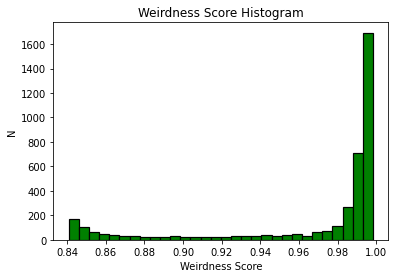

In [76]:
#Plot of Weirdness as a histogram for all objects.
sum_vec=dis_matrix
plt.rcParams['figure.figsize'] = 6, 4
plt.title("Weirdness Score Histogram")
tmp = plt.hist(dis_matrix, bins=30, color="g", edgecolor='black', linewidth=1.2)
plt.ylabel("N")
plt.xlabel("Weirdness Score")

In [72]:
N_outliers = 200
obj_ids = numpy.arange(flux.shape[0])
sum_vec_outliers = numpy.sort(sum_vec)[::-1][:N_outliers]
obj_ids_outliers = obj_ids[numpy.argsort(sum_vec)][::-1][:N_outliers]


In [73]:
obj_ids_outliers

array([3617, 2963, 2182,  303,  863, 2755, 3593, 1044, 2340,  780, 3139,
       3746, 3286, 3295, 1212,  585, 1867, 3607, 1863, 3608, 1389, 1857,
       1215, 3745, 3135, 3047, 3712,  454, 3283, 2765, 1475, 1493, 3390,
       1162,  691,  501,  973, 1363,  410, 3520, 3346, 2702, 2869, 3397,
       1677, 1967, 2527, 2856, 2431, 3379, 3249, 3257,   57,  659, 3179,
       3317, 3263,  370, 3402, 3265, 1367, 2135, 1891, 3335,  112, 2130,
       2292,   33, 3477, 2096, 2184, 2053, 2070, 1332, 1128, 2180, 3015,
        806, 1660, 3495, 3835,  456, 3330, 1416, 2384, 3775, 3605,  171,
       1840, 3206,  612, 1583,  847,  304, 3426, 2301, 3872,  411, 3331,
       2458,  671,  413, 3509,  617, 1147,  215, 2824, 2111, 1145, 3819,
       2146, 1843, 1438, 2794, 3732, 2821, 2455, 1173, 3609, 2302, 3674,
       3264,  374, 2551, 2486,  439,   97, 1584, 1797, 1615,  687,  945,
       3573,  238, 3735, 3270,  107, 3823, 1451, 1006, 1556, 2954, 3856,
       1334, 3526, 1136,  860, 3456, 2114,   75, 31

In [74]:
sum_vec_outliers

array([0.99837335, 0.99836303, 0.99834753, 0.99816163, 0.99814098,
       0.99812548, 0.9980945 , 0.99808934, 0.99808934, 0.99805319,
       0.99805319, 0.99793958, 0.99793442, 0.99792925, 0.99791893,
       0.99790343, 0.99790343, 0.99786212, 0.99786212, 0.99786212,
       0.99784663, 0.99784147, 0.99782597, 0.99782597, 0.99782597,
       0.99780532, 0.99780015, 0.99778983, 0.99778466, 0.99775368,
       0.99774852, 0.99774335, 0.99773302, 0.99773302, 0.99772786,
       0.9977227 , 0.99770204, 0.99770204, 0.99769171, 0.99768138,
       0.99767622, 0.99766589, 0.99766589, 0.99765556, 0.9976504 ,
       0.99764524, 0.99763491, 0.99763491, 0.99763491, 0.99760909,
       0.99760909, 0.99760909, 0.9975936 , 0.99758843, 0.99758843,
       0.9975781 , 0.99757294, 0.99756778, 0.99756778, 0.99755229,
       0.99754712, 0.99754196, 0.99753163, 0.99753163, 0.9975213 ,
       0.99751097, 0.99750065, 0.99750065, 0.99750065, 0.99749548,
       0.99749548, 0.99749548, 0.99749548, 0.99749032, 0.99749

In [80]:
l=[1,2,3,4,5]
print(l[::-1])

[5, 4, 3, 2, 1]
